In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from datetime import datetime

#Neural Nets
import tensorflow as tf


from data_eng import get_raw_data, get_selected_stocks
from dotenv import load_dotenv

import os
import warnings

load_dotenv()
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# Get data 
sp500_comp, spx_index, sp500_stock_data = get_raw_data()
top_100_mkt_cap_df, top_100_mkt_cap_prices_df = get_selected_stocks(sp500_stock_data)

In [4]:
#Cálculo dos pesos dos portfolios 

# Calculate daily returns
stocks_returns    = np.log(top_100_mkt_cap_prices_df / top_100_mkt_cap_prices_df.shift(1))
sp500_idx_returns =  np.log(spx_index / spx_index.shift(1))


mkt_portfolio_weights = top_100_mkt_cap_df.div(top_100_mkt_cap_df.sum(axis=1),axis=0)

#DWP portfolio
p = 0.5
power_p_transform = mkt_portfolio_weights.apply(lambda mu: mu**p,axis=0 )
dwp_portfolio_weights = power_p_transform.div(power_p_transform.sum(axis=1),axis=0 )

In [6]:
# Calculo dos retornos dos portfolios
# O shift nos pesos considera que as compras das ações com os pesos calculados em D0 
# sejam efetuadas no final do dia, recebendo assim o retorno das ações no fechamento do dia seguinte

#Retorno do portfólio de mercado
mkt_return = (mkt_portfolio_weights.shift(1) * stocks_returns).sum(axis=1)

# Retorno do Portfólio DWP
dwp_return = (dwp_portfolio_weights.shift(1) * stocks_returns).sum(axis=1)


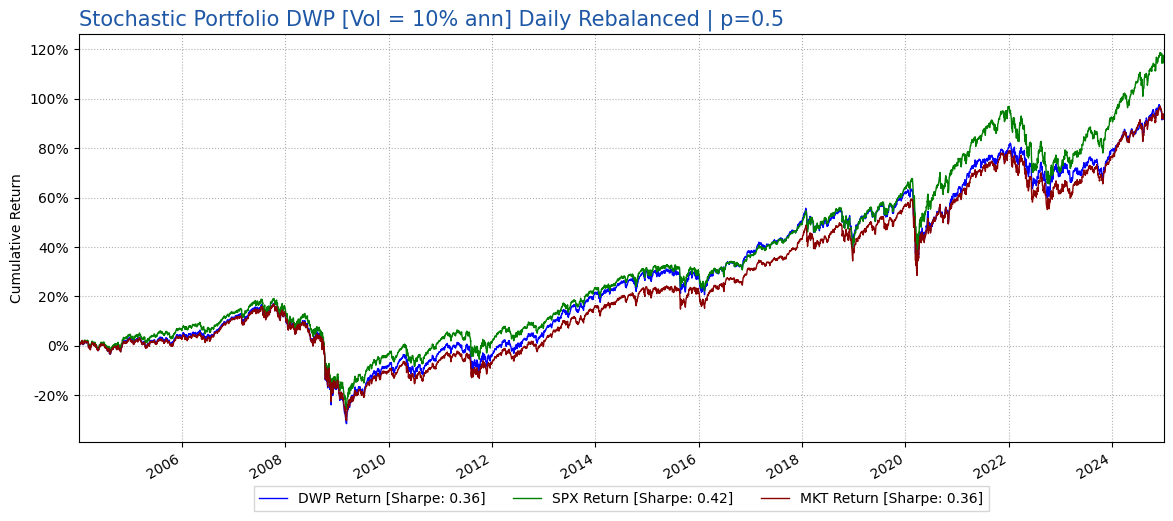

In [7]:
# Normalize every strategy to 10% ann vol (ex-post)
def plot_cumulative_returns(series_dict, p_value, target_vol=0.1):
    """
    Plot cumulative returns for multiple series normalized to target volatility.
    
    Parameters:
    -----------
    series_dict : dict
        Dictionary with series names as keys and pandas Series as values
    p_value : float
        DWP portfolio parameter p
    target_vol : float, optional
        Target annualized volatility (default: 0.1 for 10%)
    """
    # Normalize series to target volatility
    normalized_series = {}
    sharpe_ratios = {}
    
    for name, series in series_dict.items():
        # Calculate volatility scaler
        vol_scaler = target_vol / series.std() / np.sqrt(252)
        normalized_series[name] = series * vol_scaler
        
        # Calculate Sharpe ratio
        sharpe_ratios[name] = np.sqrt(252) * normalized_series[name].mean() / normalized_series[name].std()
    
    # Create plot
    plt.figure(figsize=(14,6))
    ax = plt.subplot(1,1,1)
    
    # Plot each series
    colors = {'dwp': 'blue', 'spx': 'green', 'mkt': 'darkred'}
    for name, series in normalized_series.items():
        label = f'{name.upper()} Return [Sharpe: {sharpe_ratios[name]:.2f}]'
        ((series+1).cumprod()-1).plot(label=label, linewidth=1.0, color=colors.get(name, 'gray'))
    
    # Format plot
    plt.grid(linestyle=':')
    ax.margins(x=0)
    ax.yaxis.set_major_formatter(lambda x,y : f'{x:.0%}')
    ax.set_xlabel(None)
    ax.set_ylabel('Cumulative Return')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), fancybox=False, shadow=False, ncol=3)
    plt.title(f'Stochastic Portfolio DWP [Vol = {target_vol:.0%} ann] Daily Rebalanced | p={p_value}', 
              loc='left', fontsize=15, color=(29/255, 87/255, 165/255))
    plt.show()


series_dict = {
    'dwp': dwp_return,
    'spx': sp500_idx_returns['spx_index'].reindex(mkt_return.index),
    'mkt': mkt_return
}
plot_cumulative_returns(series_dict, p)

In [6]:
##################################################
# # MONTAGEM DAS AMOSTRAS DE TREINO E DE TESTE # #
##################################################


# Copiando os dados gerados anteriormente 
# Pesos do Portfolio de mercado
mu_t_df = mkt_portfolio_weights.copy()

# Retorno das ações
R_t_df =  stocks_returns.copy()

#Retorno do portfólio de mercado
#Iloc[1:] para iniciar as series em 2004-01-05 e eliminar os valores NaN decorrentes do calculo do retorno. 
mu                   = tf.convert_to_tensor(mu_t_df.iloc[1:].values, dtype=tf.float32) # Pesos de mercado
mkt_ret              = tf.convert_to_tensor(mkt_return.iloc[1:], dtype=tf.float32)              # Retorno do portfólio de mercado
R_t_df               = tf.convert_to_tensor(R_t_df.iloc[1:].values, dtype=tf.float32)

indices = np.arange(len(mu))
train_idx, test_idx = train_test_split(indices, test_size=0.1, shuffle=False)

# Split datasets

#Treino
mu_train            = tf.convert_to_tensor(mu.numpy()[train_idx], dtype=tf.float32)
mkt_ret_train       = tf.convert_to_tensor(mkt_ret.numpy()[train_idx] , dtype=tf.float32)
stock_returns_train = tf.gather(R_t_df, train_idx)

# Teste
mu_test            = tf.convert_to_tensor(mu.numpy()[test_idx], dtype=tf.float32)
mkt_ret_test       = tf.convert_to_tensor(mkt_ret.numpy()[test_idx], dtype=tf.float32)
stock_returns_test = tf.gather(R_t_df, test_idx)


# Input da rede
training_input = tf.concat([mu_train, stock_returns_train], axis=1)
test_input     = tf.concat([mu_test,  stock_returns_test], axis=1)

input_dim =  training_input.shape[1] # 200

In [1]:
##################################################
############### DESIGN DA REDE ###################
##################################################

class PINN(tf.keras.Model):
    def __init__(self, input_dim=200):
        """
        Inicializa o modelo PINN com uma arquitetura otimizada para aprender
        funções suaves (C^2) e côncavas.

        Args:
            input_dim (int): A dimensionalidade da entrada da rede (padrão: 200).
        """
        super(PINN, self).__init__()
        
        initializer = tf.keras.initializers.GlorotNormal()
        l2_regularizer = tf.keras.regularizers.l2(0.001)

        # O corpo principal da rede é definido usando tf.keras.Sequential
        # para maior clareza e manutenibilidade.
        self.hidden_layers = tf.keras.Sequential([
            # Camada de Entrada
            tf.keras.layers.InputLayer(input_shape=(input_dim,)),
            
            # Bloco Oculto 1
            # Usamos 'swish' por ser suave (C^∞) e ter ótimo desempenho.
            # A arquitetura de largura constante (128 neurônios) é robusta.
            tf.keras.layers.Dense(20, activation='swish', kernel_initializer=initializer),
            tf.keras.layers.BatchNormalization(),
            
            # Bloco Oculto 2
            tf.keras.layers.Dense(20, activation='swish', kernel_initializer=initializer, kernel_regularizer=l2_regularizer),
            tf.keras.layers.BatchNormalization(),
            
            # Bloco Oculto 3
            tf.keras.layers.Dense(20, activation='swish', kernel_initializer=initializer, kernel_regularizer=l2_regularizer),
            # Nota: Dropout foi removido para garantir derivadas mais estáveis.
        ])
        
        # A camada de saída permanece a mesma, pois 'softplus' garante G > 0.
        self.output_layer = tf.keras.layers.Dense(1, activation='softplus')

    def call(self, inputs):
        """
        Executa a passagem para a frente (forward pass).
        A lógica de separação e concatenação foi removida por ser redundante.
        """
        z = self.hidden_layers(inputs)
        return self.output_layer(z)

NameError: name 'tf' is not defined

In [ ]:
import tensorflow as tf

def custom_loss(model, x, ret, ret_mkt):
    # Precompute D_p and its derivatives analytically
    eps = 1e-8
    sqrt_x = tf.sqrt(x + eps)  # [batch_size, n]
    s = tf.reduce_sum(sqrt_x, axis=1)  # [batch_size]
    D_p = tf.square(s)  # [batch_size]
    
    # Gradient of D_p (analytical)
    inv_sqrt_x = 1.0 / sqrt_x  # [batch_size, n]
    grad_D_p = tf.expand_dims(s, axis=1) * inv_sqrt_x  # [batch_size, n]
    
    # Hessian of D_p (analytical)
    diag_correction = -0.5 * tf.expand_dims(s, axis=1) * tf.pow(x + eps, -1.5)  # [batch_size, n]
    A = 0.5 * tf.expand_dims(inv_sqrt_x, 1) * tf.expand_dims(inv_sqrt_x, 2)  # [batch_size, n, n]
    H_D_p = A + tf.linalg.diag(diag_correction)  # [batch_size, n, n]

    # Compute G and its gradients
    with tf.GradientTape() as tape1:
        tape1.watch(x)
        inputs = tf.concat([x, ret], axis=1)
        G_x_pred = model(inputs)  # [batch_size, 1]
    
    # First-order gradient of G
    grad_G_pred = tape1.gradient(G_x_pred, x)  # [batch_size, n]
    
    # Second-order gradient (Hessian) of G
    with tf.GradientTape() as tape2:
        tape2.watch(x)
        inputs = tf.concat([x, ret], axis=1)
        grad_G_pred_ = model(inputs)  # We'll recompute to avoid persistent tape
    H_G_pred = tape2.batch_jacobian(grad_G_pred_, x)  # [batch_size, n, n]

    #############################################
    #          PERDA MSE DAS FUNÇÕES           #
    #############################################
    loss_func = G_x_pred - tf.expand_dims(D_p, axis=1)
    mse = tf.reduce_mean(tf.square(loss_func))
    
    #############################################
    #          PERDAS DAS HESSIANAS            #
    #############################################
    H_diff = H_G_pred - H_D_p
    hessian_loss = tf.reduce_mean(tf.square(tf.norm(H_diff, ord='fro', axis=[1, 2])))
    
    #############################################
    #          PERDAS DOS GRADIENTES           #
    #############################################
    grad_diff = grad_G_pred - grad_D_p
    gradient_loss = tf.reduce_mean(tf.square(tf.norm(grad_diff, ord='euclidean', axis=1)))
    
    #############################################
    #            PERDA TOTAL                   #
    #############################################
    total_loss = mse + 0.5*gradient_loss + 0.25*hessian_loss

    return total_loss, {
        'excess_return_series': loss_func,
        'grad_log_G_X_norm': tf.norm(grad_G_pred, ord='euclidean', axis=1),
    }

In [9]:
# # Função de perda customizada (physics-informed)
# def custom_loss(model, x, ret, ret_mkt):
#     """_summary_

#     Args:
#         model (_type_): Keras Model
#         x (_type_): Market Weights
#         ret (_type_): Stocks Returns
#         ret_mkt (_type_): Market portfolio return

#     Returns:
#         _type_: loss
#     """
#     with tf.GradientTape(persistent=True) as tape2:
#         tape2.watch(x)
#         with tf.GradientTape(persistent=True) as tape:
#             tape.watch(x)
            
#             G_x_pred = model(tf.concat([x, ret], axis=1))
#             log_G_x_pred = tf.math.log(G_x_pred + 1e-7)
#             D_p = tf.pow(tf.reduce_sum(tf.pow(x, 0.5), axis=1), 1.0 / 0.5)

#         # Gradientes 
#         grad_G_pred = tape.gradient(G_x_pred, x)
#         grad_D_p    = tape.gradient(D_p, x)
#     # Hessianos
#     H_G_pred = tape2.batch_jacobian(grad_G_pred, x)
#     H_D_p    = tape2.batch_jacobian(grad_D_p, x)


#     #############################################
#     # # RETORNO DO PORTFOLIO GERADO PELA REDE # #
#     #############################################
#     grad_log_G_X = tape.gradient(log_G_x_pred, x)
#     inner_prod = tf.reduce_sum(x * grad_log_G_X, axis=1)
#     pi_t = ((grad_log_G_X + 1) - tf.expand_dims(inner_prod, axis=1))*x
#     pi_t_shifted = tf.concat([tf.zeros_like(pi_t[:1]), pi_t[:-1]], axis=0)
#     port_ret = tf.reduce_sum(pi_t_shifted * ret, axis=1)

#     #############################################
#     # #        RETORNO DO PORTFOLIO DWP       # #
#     #############################################
#     power_p_transf = tf.math.sqrt(x)
#     sum_power = tf.reduce_sum(power_p_transf, axis=1, keepdims=True)
#     dwp_w = power_p_transf / sum_power

#     # aplica o shift nas alocações (para usar os pesos de t-1)
#     dwp_w_shifted = tf.concat([tf.zeros_like(dwp_w[:1]), dwp_w[:-1]], axis=0)

#     # retorno do portfólio DWP no tempo t
#     dwp_ret = tf.reduce_sum(dwp_w_shifted * ret, axis=1)

#     # retornos dos portfólios
#     loss = tf.math.cumsum(port_ret) - tf.math.cumsum(dwp_ret)
#     mse =  tf.reduce_mean(tf.square(loss))
    
#     #############################################
#     # #          PERDAS DAS HESSIANAS         # #
#     #############################################

#     hess_G_loss = tf.reduce_mean(tf.reduce_sum(tf.square(H_G_pred), axis=[1, 2]))
#     hess_D_loss = tf.reduce_mean(tf.reduce_sum(tf.square(H_D_p), axis=[1, 2]))

#     hessian_loss = hess_G_loss + hess_D_loss

#     #############################################
#     # #          PERDAS DOS GRADIENTES        # #
#     #############################################

#     grad_G_loss = tf.reduce_mean(tf.reduce_sum(tf.square(grad_G_pred), axis=1))
#     grad_D_loss = tf.reduce_mean(tf.reduce_sum(tf.square(grad_D_p), axis=1))

#     gradient_loss = grad_G_loss + grad_D_loss

#     #############################################
#     # #            PERDA TOTAL                # #
#     #############################################
    
#     total_loss = (mse +  0.5*gradient_loss + 0.25*hessian_loss)

#     return total_loss, {
#             'excess_return_series': loss,
#             'grad_log_G_X_norm': tf.norm(grad_log_G_X, ord='euclidean', axis=1),
#          }

In [10]:
# Prepara o banco de dados  (sem embaralhamento para manter a dependencia tempral das series)
batch_size = 126
dataset = tf.data.Dataset.from_tensor_slices(
    (mu_train, stock_returns_train, mkt_ret_train)
).batch(batch_size)

# Model Compilation
model = PINN(input_dim=200)  # 100 (x) + 100 (r_t) = 200
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01)


###########################################################
## Vetores para armazenamento de métricas de Treinamento ##
###########################################################
avg_epoch_loss_vect = []

grad_norms_per_epoch = {}
excess_of_ret_per_epoch = {}

grad_norms_batch_vect     = []
excess_ret_per_batch_vect = []


# Training loop (batches processed in sequence)
num_epochs = 1500
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    for x_batch, ret_batch, ret_mkt_batch in dataset:
        with tf.GradientTape() as tape:
            loss_value, metrics_dics = custom_loss(model, x_batch, ret_batch, ret_mkt_batch)

        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        grad_norms_batch_vect = grad_norms_batch_vect + metrics_dics['grad_log_G_X_norm'].numpy().tolist()
        excess_ret_per_batch_vect = excess_ret_per_batch_vect + metrics_dics['excess_return_series'].numpy().tolist()

        epoch_loss += loss_value.numpy()
        num_batches += 1

    avg_epoch_loss = epoch_loss / num_batches
    
    avg_epoch_loss_vect.append(avg_epoch_loss)
    grad_norms_per_epoch[str(epoch)]  = grad_norms_batch_vect
    excess_of_ret_per_epoch[str(epoch)]  = excess_ret_per_batch_vect

    grad_norms_batch_vect     = []
    excess_ret_per_batch_vect = []

    # Print average Epoch loss
    if epoch % 1==0:
        print(f"Epoch {epoch}/{num_epochs}, Avg Loss: {avg_epoch_loss}")

print(f"Epoch {epoch}/{num_epochs}, Avg Loss: {avg_epoch_loss}")

Epoch 0/1500, Avg Loss: 11461277696.0
Epoch 1/1500, Avg Loss: 11450256384.0
Epoch 2/1500, Avg Loss: 11439233024.0
Epoch 3/1500, Avg Loss: 11437413376.0
Epoch 4/1500, Avg Loss: 11437548544.0
Epoch 5/1500, Avg Loss: 11436232704.0
Epoch 6/1500, Avg Loss: 11435563008.0
Epoch 7/1500, Avg Loss: 11434973184.0
Epoch 8/1500, Avg Loss: 11434146816.0
Epoch 9/1500, Avg Loss: 11435168768.0
Epoch 10/1500, Avg Loss: 11433903104.0
Epoch 11/1500, Avg Loss: 11431862272.0
Epoch 12/1500, Avg Loss: 11435033600.0
Epoch 13/1500, Avg Loss: 11437216768.0
Epoch 14/1500, Avg Loss: 11430219776.0
Epoch 15/1500, Avg Loss: 11429912576.0
Epoch 16/1500, Avg Loss: 11428038656.0
Epoch 17/1500, Avg Loss: 11426454528.0
Epoch 18/1500, Avg Loss: 11424471040.0
Epoch 19/1500, Avg Loss: 11431042048.0
Epoch 20/1500, Avg Loss: 11424199680.0
Epoch 21/1500, Avg Loss: 11438646272.0
Epoch 22/1500, Avg Loss: 11425795072.0
Epoch 23/1500, Avg Loss: 11423603712.0
Epoch 24/1500, Avg Loss: 11421975552.0
Epoch 25/1500, Avg Loss: 1142011904

KeyboardInterrupt: 

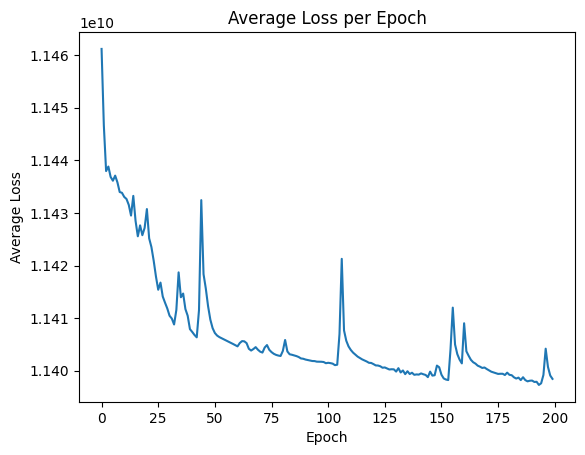

In [ ]:
plt.plot(avg_epoch_loss_vect)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss per Epoch")
plt.show()

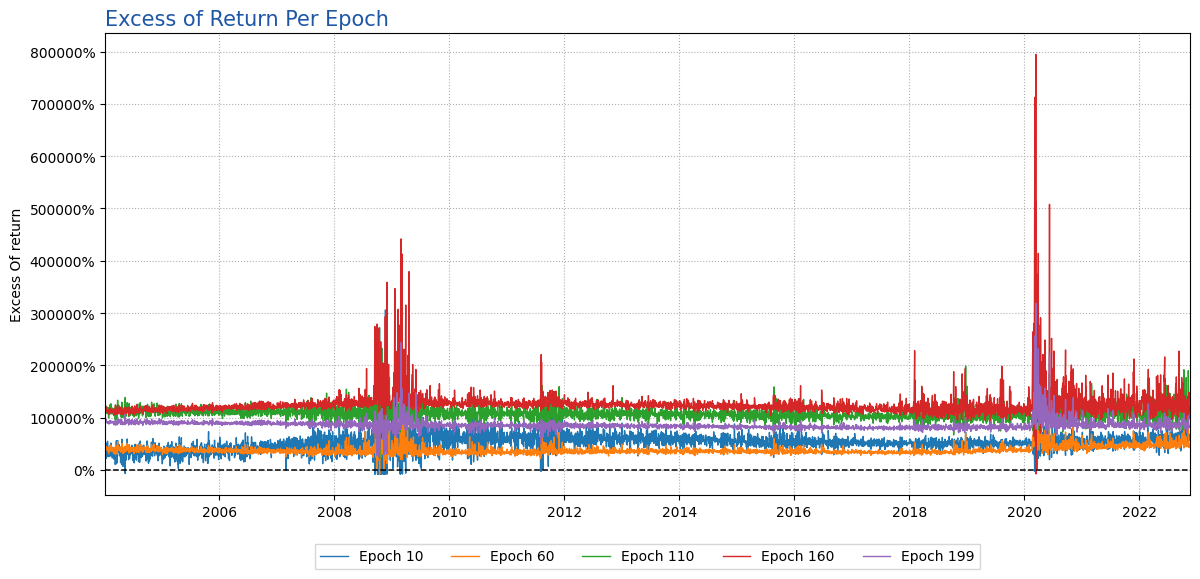

In [ ]:
plt.figure(figsize=(14,6))
ax = plt.subplot(1,1,1)

epochs_analysed = [str(i) for i in range(10,len(excess_of_ret_per_epoch),50)]+[str(len(excess_of_ret_per_epoch)-1)]

for i in epochs_analysed: 
    plt.plot(mu_t_df.iloc[1:4723].index, excess_of_ret_per_epoch[i],label=f'Epoch {i}', linewidth=1.0)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.1)
plt.grid(linestyle=':')
ax.margins(x=0)
ax.yaxis.set_major_formatter(lambda x,y : f'{x:.0%}')
ax.axes.set_xlabel(None)
ax.axes.set_ylabel('Excess Of return')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),fancybox=False, shadow=False, ncol=10)
plt.title(f'Excess of Return Per Epoch', loc='left', fontsize=15, color=(29/255, 87/255, 165/255))
plt.show()

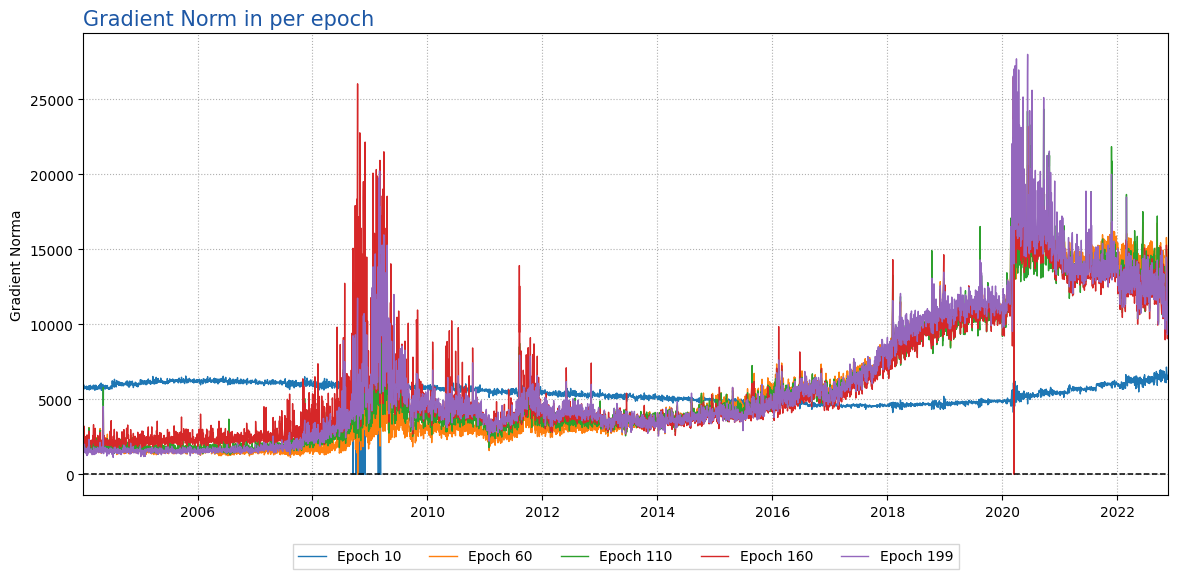

In [ ]:
plt.figure(figsize=(14,6))
ax = plt.subplot(1,1,1)

epochs_analysed = [str(i) for i in range(10,len(grad_norms_per_epoch),50)]+[str(len(grad_norms_per_epoch)-1)]

for i in epochs_analysed: 
    plt.plot(mu_t_df.iloc[1:4723].index, grad_norms_per_epoch[i],label=f'Epoch {i}', linewidth=1.0)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.1)
plt.grid(linestyle=':')
ax.margins(x=0)
#ax.yaxis.set_major_formatter(lambda x,y : f'{x:.0%}')
ax.axes.set_xlabel(None)
ax.axes.set_ylabel('Gradient Norma')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),fancybox=False, shadow=False, ncol=10)
plt.title(f'Gradient Norm in per epoch', loc='left', fontsize=15, color=(29/255, 87/255, 165/255))
plt.show()

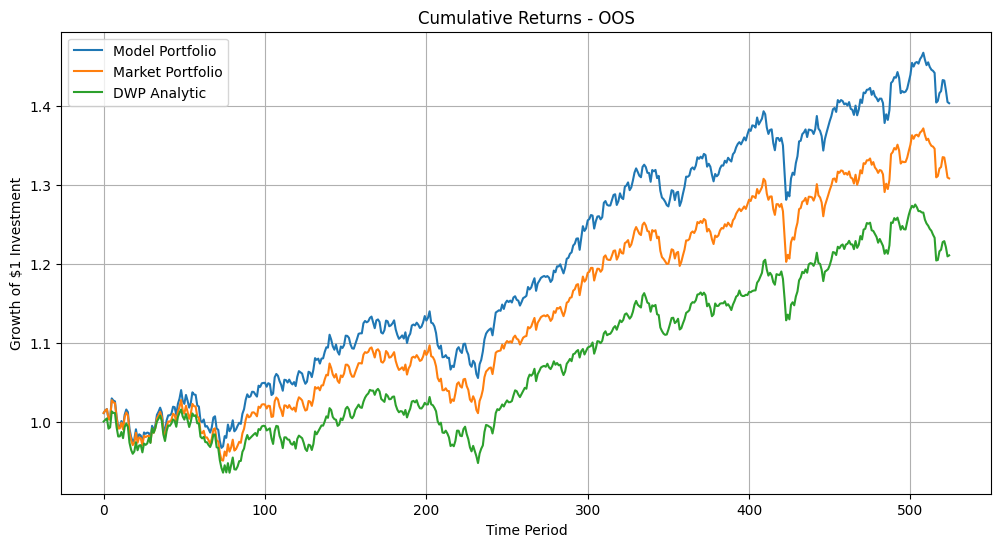

In [ ]:
# ##################################################
# ########### TEST SET EVALUATION ##################
# ##################################################

# # Compute portfolio returns on the test set
with tf.GradientTape() as tape:
    tape.watch(mu_test)
    # Generate predictions in inference mode
    test_inputs = tf.concat([mu_test, stock_returns_test], axis=1)
    G_test = model(test_inputs, training=False)  # Disable dropout/bn training
    log_G_test = tf.math.log(G_test)

# Calculate gradients for portfolio weights
grad_log_G_mu_test = tape.gradient(log_G_test, mu_test)

# Compute portfolio weights (pi_t)
inner_prod_test = tf.reduce_sum(mu_test * grad_log_G_mu_test, axis=1, keepdims=True)
grad_log_G_plus_1_test = grad_log_G_mu_test + 1.0
sum_terms_test = grad_log_G_plus_1_test - inner_prod_test
pi_t_test = sum_terms_test * mu_test

# Calculate portfolio returns
port_ret_test = tf.reduce_sum(pi_t_test * stock_returns_test, axis=1)

# Convert to numpy for analysis
port_ret_test_np = port_ret_test.numpy()
market_ret_test_np = mkt_ret_test.numpy().flatten()  # Market returns

# DWP Cumulative Return - OOS

p = 0.5
transf_p = tf.pow(mu_test, p)
row_sums = tf.reduce_sum(transf_p, axis=1, keepdims=True)
dwp_port_wgt = transf_p / row_sums  # shape (525, 100)
dwp_port_wgt_shifted = tf.concat([tf.zeros((1, tf.shape(dwp_port_wgt)[1])), dwp_port_wgt[:-1]], axis=0)
dwp_R = tf.reduce_sum(dwp_port_wgt_shifted * stock_returns_test, axis=1)  # shape (525,)

# Calculate cumulative returns
cumulative_model = np.cumprod(1 + port_ret_test_np)
cumulative_market = np.cumprod(1 + market_ret_test_np)
cumulative_DWP = tf.math.cumprod(1 + dwp_R)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_model, label="Model Portfolio")
plt.plot(cumulative_market, label="Market Portfolio")
plt.plot(cumulative_DWP.numpy(), label="DWP Analytic")
plt.title("Cumulative Returns - OOS")
plt.xlabel("Time Period")
plt.ylabel("Growth of $1 Investment")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import numpy as np

def calcular_g_x_t(df, p):
    return np.power(np.sum(np.pow(df,p),axis=1), 1/p)

In [ ]:
G_p = calcular_g_x_t(mu.numpy(), 0.5)

inputs = tf.concat([mu, R_t_df], axis=1)
G_p_nn = model(inputs, training=False)



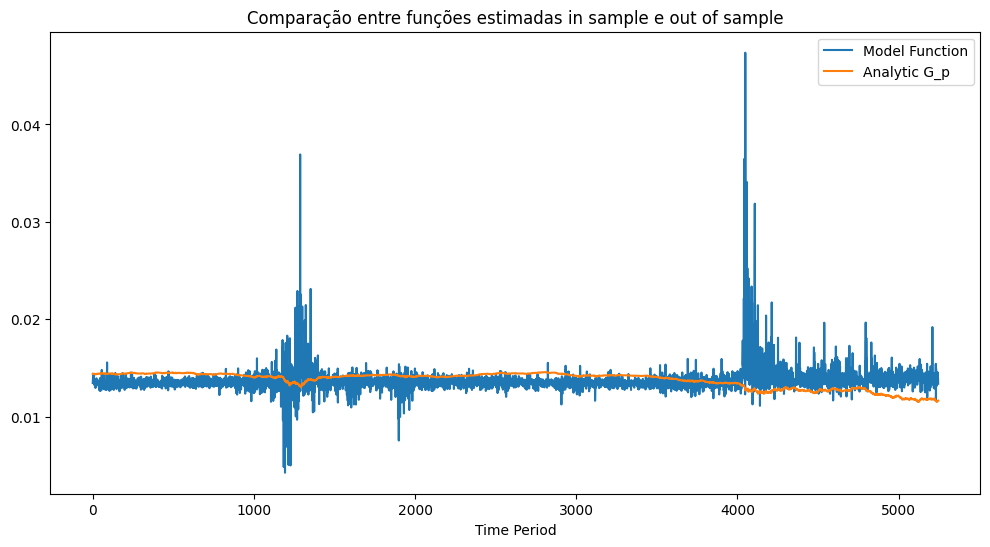

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(G_p_nn.numpy()/(np.sqrt( np.sum(G_p_nn.numpy()**2) )), label="Model Function")
plt.plot(G_p/(np.sqrt( np.sum(G_p**2) )), label="Analytic G_p")
plt.title("Comparação entre funções estimadas in sample e out of sample")
#plt.title("função gerada pela rede")
plt.legend()
plt.xlabel("Time Period")
plt.show()

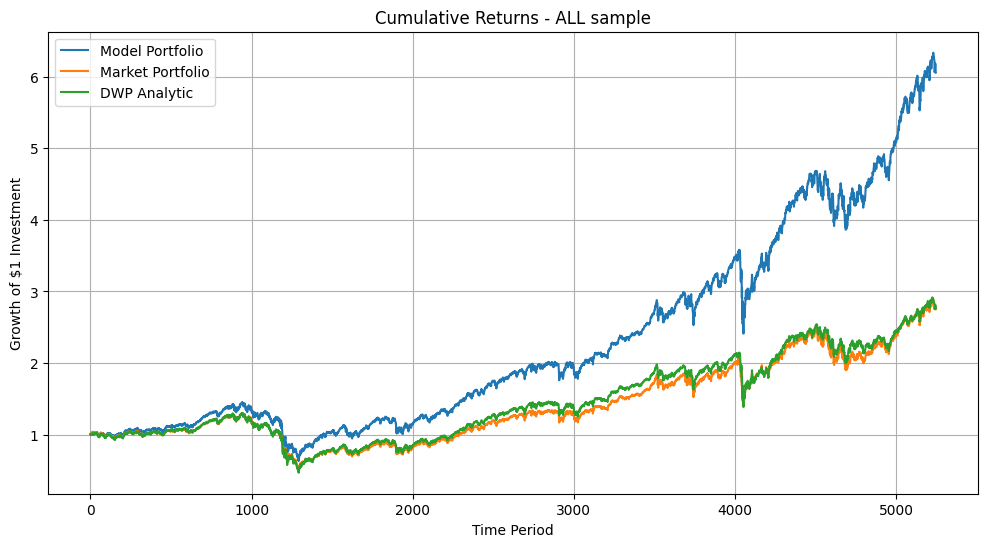

In [ ]:
# ##################################################
# ########### IN SAMPLE ##################
# ##################################################

# # Compute portfolio returns on the test set
with tf.GradientTape() as tape:
    tape.watch(mu)
    # Generate predictions in inference mode
    test_inputs = tf.concat([mu, R_t_df], axis=1)
    G_test = model(test_inputs, training=False)  # Disable dropout/bn training
    log_G = tf.math.log(G_test)

# Calculate gradients for portfolio weights
grad_log_G_mu = tape.gradient(log_G, mu)

# Compute portfolio weights (pi_t)
inner_prod_test = tf.reduce_sum(mu * grad_log_G_mu, axis=1, keepdims=True)
grad_log_G_plus_1_test = grad_log_G_mu + 1.0
sum_terms_test = grad_log_G_plus_1_test - inner_prod_test
pi_t_test = sum_terms_test * mu

# Calculate portfolio returns
port_ret_test = tf.reduce_sum(pi_t_test * R_t_df, axis=1)

# Convert to numpy for analysis
port_ret_test_np = port_ret_test.numpy()
market_ret_test_np = mkt_ret.numpy().flatten()  # Market returns

# DWP Cumulative Return - OOS
p = 0.5
transf_p = tf.pow(mu, p)
row_sums = tf.reduce_sum(transf_p, axis=1, keepdims=True)
dwp_port_wgt = transf_p / row_sums  # shape (525, 100)
dwp_port_wgt_shifted = tf.concat([tf.zeros((1, tf.shape(dwp_port_wgt)[1])), dwp_port_wgt[:-1]], axis=0)
dwp_R = tf.reduce_sum(dwp_port_wgt_shifted * R_t_df, axis=1)  # shape (525,)

# Calculate cumulative returns
cumulative_model = np.cumprod(1 + port_ret_test_np)
cumulative_market = np.cumprod(1 + market_ret_test_np)
cumulative_DWP = tf.math.cumprod(1 + dwp_R)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_model, label="Model Portfolio")
plt.plot(cumulative_market, label="Market Portfolio")
plt.plot(cumulative_DWP.numpy(), label="DWP Analytic")
plt.title("Cumulative Returns - ALL sample")
plt.xlabel("Time Period")
plt.ylabel("Growth of $1 Investment")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
import tensorflow as tf
import numpy as np

##################################################
############### DESIGN DA REDE ###################
##################################################

class PINN(tf.keras.Model):
    def __init__(self, input_dim=200):
        """
        Inicializa o modelo PINN com uma arquitetura otimizada para aprender
        funções suaves (C^2) e côncavas com convergência acelerada.
        """
        super(PINN, self).__init__()
        
        # Inicializador Xavier melhorado para PINNs
        initializer = tf.keras.initializers.GlorotUniform()
        l2_regularizer = tf.keras.regularizers.l2(1e-4)  # Reduzido para permitir mais flexibilidade

        # Arquitetura melhorada com skip connections
        self.layer1 = tf.keras.layers.Dense(128, activation='swish', 
                                          kernel_initializer=initializer)
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.layer2 = tf.keras.layers.Dense(128, activation='swish', 
                                          kernel_initializer=initializer,
                                          kernel_regularizer=l2_regularizer)
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.layer3 = tf.keras.layers.Dense(128, activation='swish', 
                                          kernel_initializer=initializer,
                                          kernel_regularizer=l2_regularizer)
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        # Camada adicional para melhor aproximação
        self.layer4 = tf.keras.layers.Dense(64, activation='swish', 
                                          kernel_initializer=initializer,
                                          kernel_regularizer=l2_regularizer)
        self.bn4 = tf.keras.layers.BatchNormalization()
        
        # Saída com inicialização pequena
        self.output_layer = tf.keras.layers.Dense(1, activation='softplus',
                                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))

    def call(self, inputs, training=None):
        """Forward pass com skip connections"""
        x = self.layer1(inputs)
        x = self.bn1(x, training=training)
        x1 = x  # Para skip connection
        
        x = self.layer2(x)
        x = self.bn2(x, training=training)
        
        x = self.layer3(x + x1)  # Skip connection
        x = self.bn3(x, training=training)
        x2 = x
        
        x = self.layer4(x)
        x = self.bn4(x, training=training)
        
        # Conexão residual final
        x = x + x2[:, :64]  # Ajuste de dimensão se necessário
        
        return self.output_layer(x)


class AdaptiveLossWeights:
    """Classe para ajustar pesos da função de perda dinamicamente"""
    def __init__(self, alpha_mse=1.0, alpha_grad=0.1, alpha_hess=0.01):
        self.alpha_mse = tf.Variable(alpha_mse, trainable=False, dtype=tf.float32)
        self.alpha_grad = tf.Variable(alpha_grad, trainable=False, dtype=tf.float32)
        self.alpha_hess = tf.Variable(alpha_hess, trainable=False, dtype=tf.float32)
        
        # Histórico para ajuste adaptativo
        self.loss_history = {'mse': [], 'grad': [], 'hess': []}
        
    def update_weights(self, mse_loss, grad_loss, hess_loss, epoch):
        """Atualiza os pesos baseado no balanceamento das perdas"""
        # Armazena histórico
        self.loss_history['mse'].append(float(mse_loss))
        self.loss_history['grad'].append(float(grad_loss))
        self.loss_history['hess'].append(float(hess_loss))
        
        # Ajuste a cada 50 épocas
        if epoch > 0 and epoch % 50 == 0:
            # Calcula médias das últimas 10 épocas
            recent_mse = np.mean(self.loss_history['mse'][-10:])
            recent_grad = np.mean(self.loss_history['grad'][-10:])
            recent_hess = np.mean(self.loss_history['hess'][-10:])
            
            # Rebalanceia para manter as perdas na mesma ordem de magnitude
            if recent_grad > 10 * recent_mse:
                self.alpha_grad.assign(self.alpha_grad * 0.8)
            elif recent_grad < recent_mse / 10:
                self.alpha_grad.assign(self.alpha_grad * 1.2)
                
            if recent_hess > 10 * recent_mse:
                self.alpha_hess.assign(self.alpha_hess * 0.7)
            elif recent_hess < recent_mse / 10:
                self.alpha_hess.assign(self.alpha_hess * 1.3)


def custom_loss_optimized(model, x, ret, ret_mkt, loss_weights, training=True):
    """Função de perda otimizada com normalização e estabilização numérica"""
    
    # Parâmetros de estabilização
    eps = 1e-6
    
    # Precompute D_p e suas derivadas (com melhor estabilização numérica)
    x_stable = tf.maximum(x, eps)  # Evita valores muito pequenos
    sqrt_x = tf.sqrt(x_stable)
    s = tf.reduce_sum(sqrt_x, axis=1)
    D_p = tf.square(s)
    
    # Normalização de D_p para evitar valores muito grandes
    D_p_normalized = D_p / (tf.reduce_mean(D_p) + eps)
    
    # Gradiente de D_p (normalizado)
    inv_sqrt_x = 1.0 / (sqrt_x + eps)
    grad_D_p = tf.expand_dims(s, axis=1) * inv_sqrt_x
    grad_D_p_norm = tf.norm(grad_D_p, axis=1, keepdims=True)
    grad_D_p_normalized = grad_D_p / (grad_D_p_norm + eps)
    
    # Hessiana de D_p (estabilizada)
    diag_correction = -0.5 * tf.expand_dims(s, axis=1) * tf.pow(x_stable, -1.5)
    A = 0.5 * tf.expand_dims(inv_sqrt_x, 1) * tf.expand_dims(inv_sqrt_x, 2)
    H_D_p = A + tf.linalg.diag(diag_correction)
    
    # Compute G e suas derivadas com gradient tape persistente
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(x)
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            inputs = tf.concat([x, ret], axis=1)
            G_x_pred = model(inputs, training=training)
        
        # Primeira derivada
        grad_G_pred = tape2.gradient(G_x_pred, x)
        
        # Normalização do gradiente
        grad_G_norm = tf.norm(grad_G_pred, axis=1, keepdims=True)
        grad_G_normalized = grad_G_pred / (grad_G_norm + eps)
    
    # Segunda derivada (Hessiana)
    H_G_pred = tape1.batch_jacobian(grad_G_pred, x)
    
    # Normalização de G
    G_normalized = G_x_pred / (tf.reduce_mean(tf.abs(G_x_pred)) + eps)
    
    #############################################
    #          PERDAS NORMALIZADAS             #
    #############################################
    
    # Perda MSE normalizada
    loss_func = G_normalized - tf.expand_dims(D_p_normalized, axis=1)
    mse_loss = tf.reduce_mean(tf.square(loss_func))
    
    # Perda do gradiente (usando gradientes normalizados)
    grad_diff_normalized = grad_G_normalized - grad_D_p_normalized
    gradient_loss = tf.reduce_mean(tf.square(tf.norm(grad_diff_normalized, axis=1)))
    
    # Perda da Hessiana (com clipping para estabilidade)
    H_diff = H_G_pred - H_D_p
    H_diff_clipped = tf.clip_by_value(H_diff, -100.0, 100.0)  # Evita explosão
    hessian_loss = tf.reduce_mean(tf.square(tf.norm(H_diff_clipped, ord='fro', axis=[1, 2])))
    
    # Perda de regularização adicional para suavidade
    smoothness_loss = tf.reduce_mean(tf.square(grad_G_norm - 1.0))  # Encoraja gradientes próximos a 1
    
    #############################################
    #            PERDA TOTAL ADAPTATIVA        #
    #############################################
    total_loss = (loss_weights.alpha_mse * mse_loss + 
                  loss_weights.alpha_grad * gradient_loss + 
                  loss_weights.alpha_hess * hessian_loss +
                  0.001 * smoothness_loss)  # Pequena regularização de suavidade

    return total_loss, mse_loss, gradient_loss, hessian_loss, {
        'excess_return_series': loss_func,
        'grad_log_G_X_norm': grad_G_norm,
    }


# Scheduler de learning rate personalizado
def create_lr_scheduler():
    def scheduler(epoch, lr):
        if epoch < 100:
            return lr
        elif epoch < 500:
            return lr * 0.95
        elif epoch < 1000:
            return lr * 0.9
        else:
            return lr * 0.85
    return scheduler


# Configuração do modelo e treinamento otimizado
def setup_optimized_training(mu_train, stock_returns_train, mkt_ret_train):
    # Prepara o dataset com prefetch para melhor performance
    batch_size = 64  # Batch menor para gradientes mais estáveis
    dataset = tf.data.Dataset.from_tensor_slices(
        (mu_train, stock_returns_train, mkt_ret_train)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Modelo com arquitetura otimizada
    model = PINN(input_dim=200)
    
    # Otimizador com configurações melhoradas
    initial_lr = 0.001  # Learning rate menor para estabilidade
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=initial_lr,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        clipnorm=1.0  # Gradient clipping
    )
    
    # Pesos adaptativos da função de perda
    loss_weights = AdaptiveLossWeights(alpha_mse=1.0, alpha_grad=0.01, alpha_hess=0.001)
    
    # Scheduler de learning rate
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(create_lr_scheduler())
    
    return model, optimizer, loss_weights, dataset, lr_scheduler


# Loop de treinamento otimizado
def train_optimized_model(model, optimizer, loss_weights, dataset, num_epochs=1500):
    """Loop de treinamento com convergência acelerada"""
    
    # Vetores para métricas
    metrics_history = {
        'total_loss': [],
        'mse_loss': [],
        'grad_loss': [],
        'hess_loss': [],
        'learning_rate': []
    }
    
    # Early stopping
    best_loss = float('inf')
    patience = 100
    patience_counter = 0
    
    print("Iniciando treinamento otimizado...")
    
    for epoch in range(num_epochs):
        epoch_losses = {'total': 0, 'mse': 0, 'grad': 0, 'hess': 0}
        num_batches = 0
        
        for x_batch, ret_batch, ret_mkt_batch in dataset:
            with tf.GradientTape() as tape:
                total_loss, mse_loss, grad_loss, hess_loss, metrics = custom_loss_optimized(
                    model, x_batch, ret_batch, ret_mkt_batch, loss_weights, training=True
                )
            
            # Gradient clipping adicional se necessário
            gradients = tape.gradient(total_loss, model.trainable_variables)
            gradients = [tf.clip_by_norm(g, 1.0) if g is not None else g for g in gradients]
            
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Acumula perdas
            epoch_losses['total'] += float(total_loss)
            epoch_losses['mse'] += float(mse_loss)
            epoch_losses['grad'] += float(grad_loss)
            epoch_losses['hess'] += float(hess_loss)
            num_batches += 1
        
        # Calcula médias
        avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}
        
        # Atualiza pesos adaptativos
        loss_weights.update_weights(avg_losses['mse'], avg_losses['grad'], 
                                   avg_losses['hess'], epoch)
        
        # Armazena métricas
        metrics_history['total_loss'].append(avg_losses['total'])
        metrics_history['mse_loss'].append(avg_losses['mse'])
        metrics_history['grad_loss'].append(avg_losses['grad'])
        metrics_history['hess_loss'].append(avg_losses['hess'])
        metrics_history['learning_rate'].append(float(optimizer.learning_rate))
        
        # Early stopping
        if avg_losses['total'] < best_loss:
            best_loss = avg_losses['total']
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Ajuste dinâmico do learning rate
        if epoch > 0 and epoch % 100 == 0:
            if avg_losses['total'] > metrics_history['total_loss'][-100]:
                optimizer.learning_rate.assign(optimizer.learning_rate * 0.5)
                print(f"Learning rate reduzido para: {float(optimizer.learning_rate):.6f}")
        
        # Print detalhado a cada 50 épocas
        if epoch % 50 == 0 or epoch < 10:
            print(f"Epoch {epoch:4d}/{num_epochs} | "
                  f"Total: {avg_losses['total']:.2e} | "
                  f"MSE: {avg_losses['mse']:.2e} | "
                  f"Grad: {avg_losses['grad']:.2e} | "
                  f"Hess: {avg_losses['hess']:.2e} | "
                  f"LR: {float(optimizer.learning_rate):.6f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping na época {epoch}")
            break
    
    return model, metrics_history


# Exemplo de uso:
# Configuração
model, optimizer, loss_weights, dataset, lr_scheduler = setup_optimized_training(
    mu_train, stock_returns_train, mkt_ret_train
)

# Treinamento
trained_model, history = train_optimized_model(
    model, optimizer, loss_weights, dataset, num_epochs=1500
)
